In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import fortitudo.tech as ft
import scipy.io as scio
import pypfopt as pfopt
from numba import njit
from datetime import datetime
import statsmodels.api as sm

In [121]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [122]:
start_date = '2007-01-01'
end_date = '2023-08-21'

In [123]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()
AU9999 = pd.read_excel('AU9999_daily.xls').dropna()
CNbd = pd.read_excel('China_bond.xlsx').dropna()
CN10y = pd.read_excel('China_bond10y.xls').dropna()
SPX_VIX = pd.read_excel('SPX_VIX_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999, 'CNbd': CNbd, 'CN10y': CN10y, 'SPX_VIX': SPX_VIX}
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999', 'CNbd', 'CN10y', 'SPX_VIX']
datalen = [index.shape[1] for name, index in indices.items()]

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= start_date) & (index['交易时间'] <= end_date)]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for mg_name in names:
    for name, index in indices.items():
        if name== mg_name: continue
        datalen = index.shape[1]
        index = pd.merge(index, indices[mg_name], on='交易时间', how='inner', suffixes=('','_2')).iloc[:,:datalen]
        indices[name] = index
for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [124]:
# 因为重新同步了市场时间，所以需要重新计算涨跌幅
for name, index in indices.items():
    for i in range(1,index.shape[0]): #第0天不算了
        if name != 'CN10y':
            index.loc[i,'涨跌'] = index['收盘价'][i] - index['收盘价'][i-1]
            index.loc[i,'涨跌幅%'] = index.loc[i,'涨跌'] / index.loc[i-1,'收盘价'] * 100
        else:
            index.loc[i,'涨跌幅%'] = (index['收盘价'][i] - index['收盘价'][i-1]) / index.loc[i-1,'收盘价'] * 100
    index.fillna(0,inplace=True)

SPX_VIX = indices['SPX_VIX']
del indices['SPX_VIX']
names.pop()

CN10y = indices['CN10y']
del indices['CN10y']
names.pop()

'CN10y'

In [125]:
pnls = np.array([[0] * indices['A300'].shape[0]])    # 把涨跌幅做成矩阵方便使用
names = []
for name, index in indices.items():
    names.append(name)
    pnls = np.r_[pnls, np.array(index['涨跌幅%']).reshape(1,-1)]
pnls = pd.DataFrame(pnls[1:].astype('float64').T,columns = names)
display(pnls)

,A300,A500,SPX,HSI,AU9999,CNbd
0,1.275816,-0.142518,0.122829,-1.899785,-0.476964,0.000000
1,0.280104,2.714525,-0.608458,0.927314,-1.034178,0.081371
2,2.830844,4.602142,0.222031,-0.898607,-2.051740,-0.045391
3,3.215016,2.155014,-0.051669,-0.656926,0.474889,0.108988
4,2.539896,2.587916,0.194036,-1.657145,-0.071220,0.151142
...,...,...,...,...,...,...
3815,-0.729793,0.058376,0.575038,-1.581321,0.153762,0.151371
3816,-0.243030,-0.625743,-1.155083,-1.025059,0.010966,0.218419
3817,-0.733179,-0.791918,-0.755544,-1.355194,0.173246,0.151834
3818,0.334361,0.705357,-0.771286,-0.014567,-0.019703,-0.030375


## 统计特征

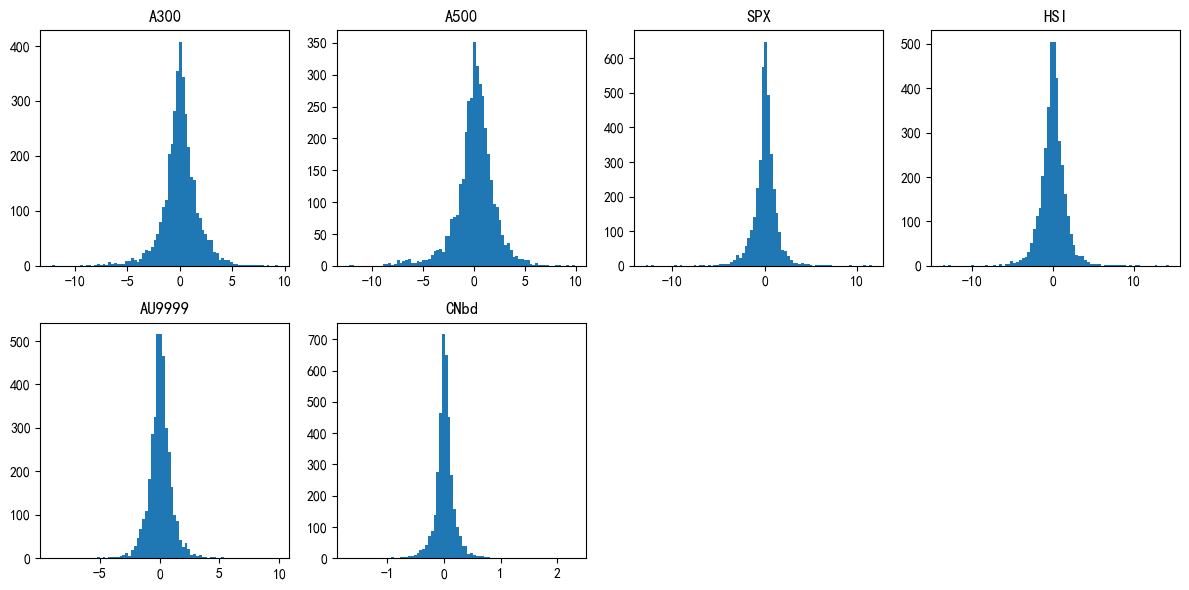

In [631]:
# 分布直方图

fig = plt.figure(figsize=(12, 6))
i = 1
for name, index in indices.items():
    ax = plt.subplot(2, 4, i)
    ax.set_title(name)
    plt.tight_layout()
    plt.hist(np.array(index['涨跌幅%']), bins=80)
    i += 1

In [632]:
# 计算期望与协方差

Mu = pnls.mean(axis = 0)
Sigma = pnls.cov()
display(np.round(Mu,3))
display(np.round(pnls.corr(), 2))   # 相关系数矩阵
display(np.round(Sigma, 2))  # 协方差矩阵

A300      0.032
A500      0.053
SPX       0.038
HSI       0.010
AU9999    0.033
CNbd      0.016
dtype: float64

,A300,A500,SPX,HSI,AU9999,CNbd
A300,1.00,0.88,0.12,0.54,0.06,-0.08
A500,0.88,1.00,0.09,0.42,0.05,-0.06
SPX,0.12,0.09,1.00,0.26,0.00,-0.04
HSI,0.54,0.42,0.26,1.00,0.10,-0.08
AU9999,0.06,0.05,0.00,0.10,1.00,0.05
CNbd,-0.08,-0.06,-0.04,-0.08,0.05,1.00


,A300,A500,SPX,HSI,AU9999,CNbd
A300,3.02,3.01,0.28,1.50,0.11,-0.03
A500,3.01,3.86,0.24,1.32,0.10,-0.02
SPX,0.28,0.24,1.79,0.56,0.00,-0.01
HSI,1.50,1.32,0.56,2.55,0.16,-0.03
AU9999,0.11,0.10,0.00,0.16,1.06,0.01
CNbd,-0.03,-0.02,-0.01,-0.03,0.01,0.04


In [633]:
# 正态性检验

alpha = 0.05
print("W正态性检验")
for i in range(pnls.shape[1]):
    if (scipy.stats.shapiro(pnls.values[:, i])[1] <= alpha):
        print(names[i], '非正态')
    else:
        print(names[i], '正态')

print("\nK-S正态性检验")
for i in range(pnls.shape[1]):
    if (scipy.stats.kstest(pnls.values[:, i], cdf='norm')[1] <= alpha):
        print(names[i], '非正态')
    else:
        print(names[i], '正态')

W正态性检验
A300 非正态
A500 非正态
SPX 非正态
HSI 非正态
AU9999 非正态
CNbd 非正态

K-S正态性检验
A300 非正态
A500 非正态
SPX 非正态
HSI 非正态
AU9999 非正态
CNbd 非正态


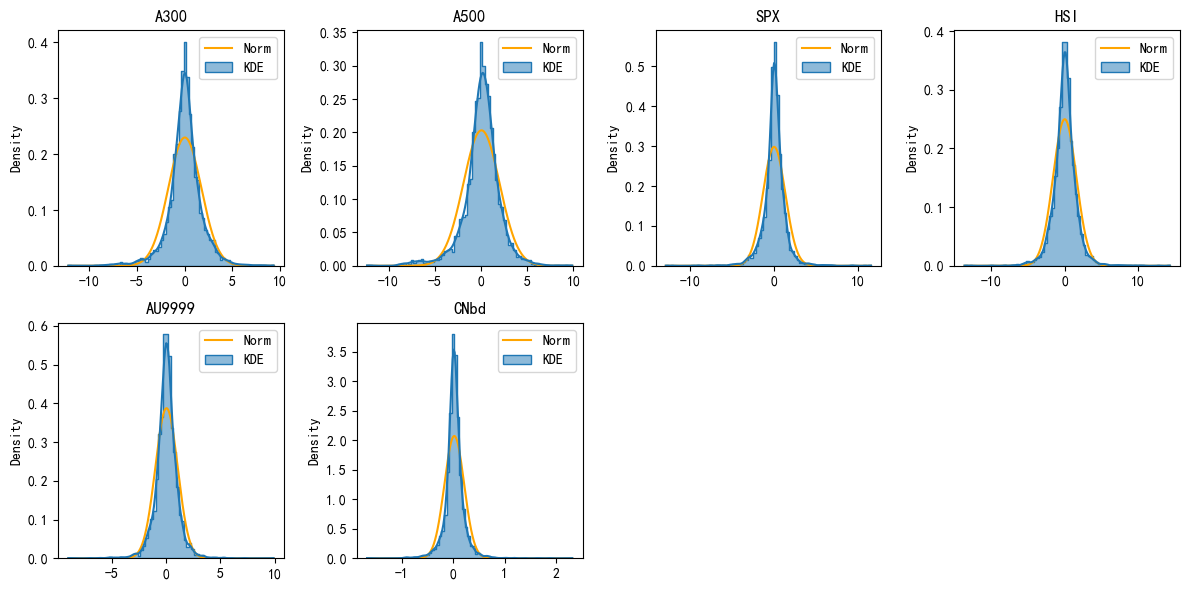

In [635]:
# 分布图
# 蓝色直方图，深蓝色核密度函数，橙色正态密度函数

fig = plt.figure(figsize=(12, 6))
i = 0
for name, index in indices.items():
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    pnl = np.array(index['涨跌幅%'])
    norm_x = np.linspace(pnl.min(), pnl.max(), 1000)
    norm_y = scipy.stats.norm.pdf(norm_x, Mu[i], np.sqrt(Sigma.values[i,i]))
    plt.plot(norm_x,norm_y,c="orange", label='Norm')
    sns.histplot(data = pnl, bins = 80, kde=True, ax = ax, element="step", stat="density", label='KDE')
    plt.legend()
    i += 1

## 熵池模型
熵池(Entropy Pooling, EP)模型通过相对熵(Relative Entropy, RE)来衡量分布之间的距离，最小化嵌入了观点和市场影响因素的后验分布和先验分布之间的RE距离来剔除多余观点，得到符合观点表述的最简后验分布。

## 解析解
正态先验总体的解析解，得到后验正态总体。

In [ ]:
def prior2posterior(mu, q, mu_q, sigma, g, sigma_g):
    """
    Analytical solution to the constrain
    X ~ (Mu, Sigma)
    E(QX) = Mu_Q
    Cov(GX) = Sigma_G
    
    minimize the KL divergence
    
    X ~ (Mu_tilda, Sigma_tilda)
    
    See the following paper for more details.

    Meucci, Attilio, Fully Flexible Views: Theory and Practice (August 8, 2008). 
    Fully Flexible Views: Theory and Practice, Risk, Vol. 21, No. 10, pp. 97-102, October 2008. 
    Available at SSRN: https://ssrn.com/abstract=1213325
    
    
    """
    mu_tilda = sigma * q.T * np.linalg.inv(q * sigma * q.T) * (mu_q - q * mu)
    tmp = np.linalg.inv(g * sigma * g.T)
    sigma_tilda = sigma + (sigma * g.T) * (tmp * sigma_g * tmp - tmp) * (g*sigma)
    return mu_tilda, sigma_tilda

In [ ]:
# 给定观点（随便设置的）
# 可将数值设置大（可能没有现实意义）一些以清晰看出图形变化

# 控制变量进行简单观点测试
# 发现即使只对一个量引入观点也会导致其他相关量变化
# 相关性越强变化越大
# Q = np.matrix([[1, 0, 0, 0, 0]])
# Mu_Q = np.array([1.1*Mu[0]+0.4]).reshape(-1, 1)  

# 复杂观点测试
Q = np.matrix([[1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 1, -1, 0],
               [1, 0, 0, 0, 1]])
Mu_Q = np.array([Mu[0]-0.3,
                 Mu[1]+0.5,
                 0.9*Mu[2] - 1.5*Mu[3] - 0.2,
                 1.1*Mu[0] + 0.9*Mu[1] - 0.4]).reshape(-1, 1)   

G = np.eye(5)
Sigma_G = 1.1 * Sigma.values   # 调整协方差矩阵以引入波动率，也可以引入其他线性组合的协方差

Mu_tilda, Sigma_tilda = prior2posterior(Mu.values.reshape(-1,1), Q, Mu_Q, Sigma.values, G, Sigma_G)
Mu_tilda = np.array(Mu_tilda)

In [ ]:
# 分布图
# 蓝色先验分布，橙色后验分布
# 结果不知道为什么均值一直是0

fig = plt.figure(figsize=(12, 6))
for i, name in enumerate(names):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    
    prior_norm_x = np.linspace(Mu[i] - 3 * np.sqrt(Sigma.values[i,i]),
                         Mu[i] + 3 * np.sqrt(Sigma.values[i,i]), 1000)
    post_norm_x = np.linspace(Mu_tilda[i] - 3 * np.sqrt(Sigma_tilda[i,i]),
                         Mu_tilda[i] + 3 * np.sqrt(Sigma_tilda[i,i]), 1000)
    
    prior_norm_y = scipy.stats.norm.pdf(prior_norm_x, Mu[i], np.sqrt(Sigma.values[i,i]))
    post_norm_y = scipy.stats.norm.pdf(post_norm_x, Mu_tilda[i], np.sqrt(Sigma_tilda[i,i]))
    
    plt.plot(prior_norm_x,prior_norm_y,c="cornflowerblue", label = 'Prior')
    plt.axvline(x=Mu[i], linestyle='--',c="cornflowerblue")
    plt.plot(post_norm_x,post_norm_y,c="orange", label='Post')
    plt.axvline(x=Mu_tilda[i], linestyle='--', c="orange")
    plt.legend()

## 数值解1 (无法运行)
EP是通过minimize RE来获得市场后验分布，但是大部分情况下总体的分布并不能被看作正态的，此时计算EP的解析解是困难的，因此需要数值解法来得到更具应用普遍性的结果

最优化任务：$argmin_{f} KL(f, g)$, g s.t. constraints，constraints为观点

也就是在函数空间内搜索一个与先验分布最相似但是满足constraints的分布

数值的方法是通过建造一个Panel $V$来表示分布

$V$ 其实就是讲市场的信息（回报率，价格，因子等等），通过观点function $g_k(...)$ 映射得来

$V_{j,k} = g_k(X_{j,1}, ..., X_{j,N})$

对于一个这样的panel, 可以形成一个JX1的向量，用来代表每个scenario下的概率，$p$  
而后验分布$\widetilde{p}$，则是我们需要通过优化得到的，用它来minimize KL-divergence

其中k代表k个观点，而j代表的是simultaion的数量  
而RE距离的连续形式可以被改成离散的形式
$E(\widetilde{p}, p) = \sum_{j=1}^J \widetilde{p}_j[ln(\widetilde{p}_j) - ln(p_j)]$

但是在Meucci的第二篇文章Fully Exterme Views中，没有采用Monte Carolo Simulation去获得V panel
而是采用类似于Grid Search的方式
作者这里使用的是Hermite Polynomial的零点作为grid

这里计算直接使用了eqaully spaced的interval

In [ ]:
def kde_scipy(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = scipy.stats.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde

def kernelbw(x):
    # Bandwith 计算
    n = len(x)
    prop = 1.0
    sig = np.std(x)
    iqrSig = 0.7413 * scipy.stats.iqr(x)
    if iqrSig == 0:
        iqrSig = sig
    bw = prop * min(sig, iqrSig) * n ** (-1/(4+1))
    return bw

def kernelpdf(x, xi, wi):
    n = len(xi)
    bw = kernelbw(xi)
    
    p = np.zeros(len(x))
    for i in range(n):
        p = p + wi[i] * scipy.stats.norm.pdf(x, loc=xi[i], scale = bw);
    return p

def kernelcdf(x, xi, wi):
    np.seterr(divide = 'ignore')    # 关闭计算警告
    n = len(xi)
    bw = kernelbw(xi)
    if type(x) is not np.ndarray:
        p = np.zeros(1)
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p[0]
    else:
        p = np.zeros(len(x))
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p
    np.seterr(divide = 'warn')    # 还原计算警告

def kernelinv(p, xi, wi):
    import collections.abc
    
    def helper(x, xi, wi, p):
        f = kernelcdf(x, xi, wi) - p
        return f

    if not isinstance(p, collections.abc.Iterable):
        sortp = p
        x = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp), maxiter=50)
        return x
    elif len(p) < 10:
        x = np.zeros(len(p))
        tmp = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, p[0]), maxiter=50)
        for i in range(len(p)):
            x[i] = tmp
        return x
    else:
        sortp = np.sort(p)
        x_min = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp[0]), maxiter=50)
        x_max = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp[len(sortp)-1]), maxiter=50)
    
        # mesh for x values
        x_ = np.linspace(x_min - 0.1 * abs(x_min), x_max + 0.1 * abs(x_max), 500)

        # evaluates the mesh on these values
        y_ = kernelcdf(x_, xi, wi);
        x = np.interp(p, y_, x_)
        return x
    
def subIntervals(x):
    n = len(X)
    xMesh = np.empty(n+1)
    xMesh[0] = X[0]
    xMesh[n] = X[n-1]
    xMesh[1:n] = X[1:] - 0.5 * (X[1:] - X[0:n-1])

    xUB = xMesh[1:] - 2.2e-308
    xLB = xMesh[0: n] 
    return xUB, xLB
def intergrateSubIntervals(x, cdf):
    xUB, xLB = subIntervals(X)
    p = (cdf(xUB) - cdf(xLB)) 
    return p

def normalizeProb(p):
    tol = 1e-20
    tmp = p
    tmp[tmp<tol] = tol
    return tmp / sum(tmp)

In [ ]:
# 这里以沪深300指数为例
xi = np.array(indices['A500']['涨跌幅%'])
n = xi.shape[0]

# bandwith
bw = kernelbw(xi)

# weights
lamb = np.log(2) / (n / 2);
wi = np.exp(-lamb * np.array(range(n)))
wi = np.array(list(reversed(wi))) / sum(wi)

mu = np.mean(xi)
pdf = lambda x: kernelpdf(x, xi, wi)
cdf = lambda x: kernelcdf(x, xi, wi)
inv = lambda x: kernelinv(x, xi, wi)
VaR95 = inv(0.05)

J = 10000
tmp = np.linspace(0, 1, 1000)
epsilon = 1e-10
Lower = inv(epsilon)
Upper = inv(1 - epsilon)
# X = Lower + tmp * (Upper - Lower)

delta = (Upper - Lower) / J
X = np.array([Lower + (2*j - 1) / 2 * delta for j in range(1, J+1)])

p = intergrateSubIntervals(X, cdf)
# p = normalizeProb(p)

In [ ]:
def nestedfunU(v):
    global lnp, Aeq, Beq
    v = v.reshape((v.shape[0], 1))

    lnx = lnp - 1 - Aeq.T * v
    
    x = np.exp(lnx)
    L = x.T * (lnx - lnp + Aeq.T * v) - Beq.T * v

    return -L[0, 0]   

In [ ]:
# Constraints

view_mu = np.mean(xi) + 1     # 收益率和波动都增加很多的情况
view_variance = np.var(xi) + 5
Aeq = np.matrix([np.ones(J), X**2, X])
Beq = np.matrix([1, view_variance, view_mu]).T

lnp = np.matrix(np.log(p)).T 

x0 = [np.random.random() for _ in range(3)]
res = scipy.optimize.minimize(nestedfunU, x0, method='BFGS', tol=1e-10)
v = res.x
v = v.reshape((v.shape[0], 1))
lnp_ = lnp - 1 - Aeq.T * v
p_ = np.array(np.exp(lnp_)).reshape(lnp_.shape[0])

prior_mean = np.dot(X, p)
posterior_mean = np.dot(X, p_)
posterior_var = np.dot(X**2, p_)

print('Mean: Prior %.5f, Post %.5f' % (np.mean(xi), posterior_mean))

print('Var: Prior %.5f, Post %.5f' % (np.var(xi), posterior_var))

plt.plot(X, p, label = 'prior', c="cornflowerblue")
plt.plot(X, p_, label = 'post', c="orange")
plt.axvline(x=np.mean(xi), linestyle='--',c="cornflowerblue")
plt.axvline(x=posterior_mean, linestyle='--',c="orange")

plt.legend()

## 数值解2
这里直接使用 fortitudo.tech 库

In [ ]:
R_df = pd.DataFrame(data=pnls[0:1000], columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(np.round(stats_prior, 2))

corr_prior = ft.correlation_matrix(R_df)
display(np.round(corr_prior, 2))

### 先验情景分布为均匀分布的情况
离散情景先验分布可以认为是均等的，因此一般采用均匀分布即可。

In [ ]:
R = R_df.values
S = R.shape[0]
p = np.ones((S, 1)) / S    # 均匀分布
means_prior = p.T @ R      # 先验均值
vols_prior = np.sqrt(p.T @ (R - means_prior)**2)    # 先验标准差和样本标准差差距很大


A300_A500_mean = (R[:, 0]-R[:, 1])[np.newaxis, :]   # A300和A500均值之差
A300_mean = (R[:, 0])[np.newaxis, :]
A500_mean = (R[:, 1])[np.newaxis, :]
SPX_mean = R[:, 3][np.newaxis, :]
HSI_kurt = (((R[:, 2] - means_prior[:, 2]) / vols_prior[:, 2])**4)[np.newaxis, :]
A500_kurt = (((R[:, 1] - means_prior[:, 1]) / vols_prior[:, 1])**4)[np.newaxis, :]

A = np.vstack((np.ones((1, S)), A300_A500_mean, A500_kurt))   # 等式约束设置
b = np.vstack(([1.0], [0.02], [7.0]))                # 第一项约束为离散分布和为1
G = np.vstack((SPX_mean, -HSI_kurt, -A300_mean, -A500_mean))
h = np.vstack(([0.01], [-12], [-0.03], [-0.05]))

q = ft.entropy_pooling(p, A, b, G, h)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)

print(f'ENS = {np.round(effective_number_scenarios[0, 0] * 100, 2)}%.')
print(f'RE = {np.round(relative_entropy[0, 0] * 100, 2)}%.')

stats_post = ft.simulation_moments(R_df, q)
display(np.round(stats_post, 2))

corr_post = ft.correlation_matrix(R_df, q)
display(np.round(corr_post, 2))

In [ ]:
fig = plt.figure(figsize=(5, 3))
plt.bar(x = np.arange(q.shape[0]), height = q.reshape(-1), width=1, alpha=0.5, label='Post')
plt.bar(x = np.arange(p.shape[0]), height = p.reshape(-1), width=1, alpha=0.5, label='Prior')
plt.xticks([])
plt.legend()

## 技术指标

### RSI

In [636]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [637]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

In [638]:
ptf_typ = 5
ptf_name = names[ptf_typ]

R1 =  RSI(prices[-1], price_moves[ptf_typ], period = 10)
R2 =  RSI(prices[-1], price_moves[ptf_typ], period = 15)
R3 =  RSI(prices[-1], price_moves[ptf_typ], period = 20)

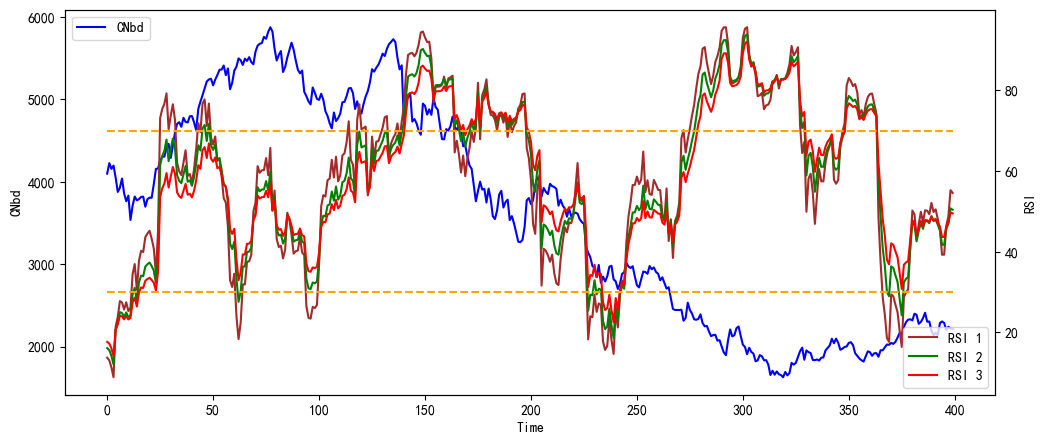

In [639]:
fig = plt.figure(figsize = (12,5))
begin = 100
end = 500
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel(ptf_name)
ax.plot(np.arange(prices[0][begin:end].shape[0]), prices[0][begin:end],color = 'blue', label = ptf_name)
ax2 = ax.twinx()
ax2.set_ylabel('RSI')
ax2.plot(np.arange(R1[begin:end].shape[0]), R1[begin:end], color = 'brown', label = 'RSI 1')
ax2.plot(np.arange(R2[begin:end].shape[0]), R2[begin:end], color = 'green', label = 'RSI 2')
ax2.plot(np.arange(R3[begin:end].shape[0]), R3[begin:end], color = 'red', label = 'RSI 3')
ax2.plot(np.arange(prices[0][begin:end].shape[0]), [70] * prices[ptf_typ][begin:end].shape[0], '--', color = 'orange')
ax2.plot(np.arange(prices[0][begin:end].shape[0]), [30] * prices[ptf_typ][begin:end].shape[0], '--', color = 'orange')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')

### 动量

In [643]:
def momentum(prices, day_ago):
    diff = np.c_[prices[:, :day_ago], prices][:,:-day_ago]
    return (prices - diff) / diff

In [644]:
mtm1 = momentum(prices, 20)

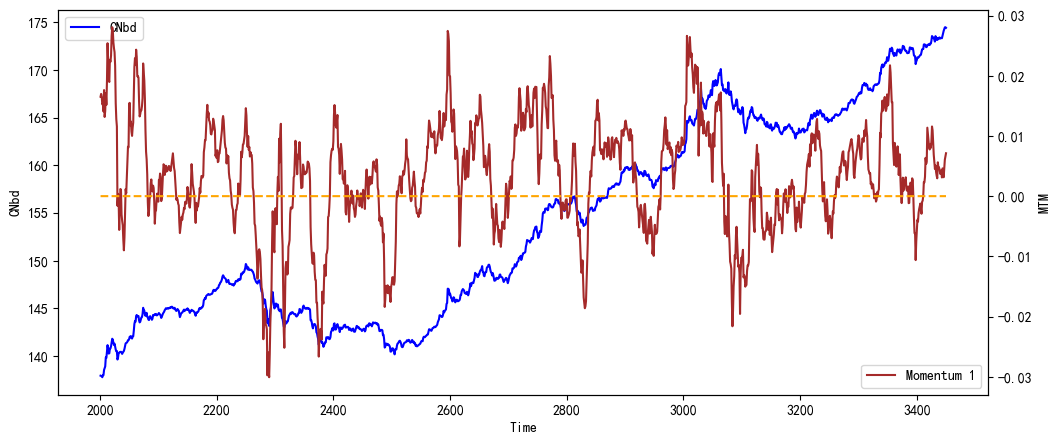

In [645]:
fig = plt.figure(figsize = (12,5))
begin = 2001
end = 3451
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel(ptf_name)
ax.plot(np.arange(begin, end), prices[ptf_typ][begin:end],color = 'blue', label = ptf_name)
ax2 = ax.twinx()
ax2.set_ylabel('MTM')
ax2.plot(np.arange(begin, end), mtm1[ptf_typ][begin:end], color = 'brown', label = 'Momentum 1')
ax2.plot(np.arange(begin, end), [0] * (end - begin), '--', color = 'orange')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')

## Monte Carlo 模拟

In [ ]:
### 测试代码
sim_times = 100
all_choice = np.arange(R.shape[0])
sim_series = []
end_time = 1028
for i in range(sim_times):
    now_price = np.array([1,1,1,1,1,1,1],dtype=np.float64)
    sim = []
    for t in range(1, end_time):
        scene = np.random.choice(all_choice, p = p.ravel())
        drive = R[scene]
        now_price = now_price * (1 + drive * 0.01)
        sim.append(now_price)
    sim = np.array(sim).T
    sim_series.append(sim)
sim_series = np.array(sim_series)

In [ ]:
win = 0
fail = 0
A300_endPrice = np.array([], dtype=np.float64)
for i in range(sim_times):
    A300_endPrice = np.append(A300_endPrice, sim_series[i][0][-1])
win = (A300_endPrice > 1).sum()
fail = (A300_endPrice < 1).sum()
    
print(f'Win rate: {win/(win+fail)}')
print(f'Exp: {np.mean(A300_endPrice)}')
print(f'Var: {np.cov(A300_endPrice)}')

fig = plt.figure(figsize=(12,5))
period = np.arange(1,end_time)
for i in range(100):
    plt.plot(period, sim_series[i][0])

## Mean-Variance P&L最优化

### 蒙特卡洛模拟加速

In [126]:
@njit    #numba加速，需要明确定义数据类型
def price_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    '''
    只记录模拟结束的价格
    '''
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_series = np.zeros((sim_times, n_ptf))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price = now_price * (1 + drive * 0.01)
        sim_series[i, :] = now_price
    return sim_series

@njit    #numba加速，需要明确定义数据类型
def path_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    '''
    记录整个模拟的价格路径
    '''
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_paths = np.zeros((sim_times, n_ptf,  sim_end_time))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price = now_price * (1 + drive * 0.01)
            sim_paths[i, :, t] = now_price
    return sim_paths

### 绘图函数

In [162]:
def draw_ptf():
    fig = plt.figure(figsize = (12,10))

    time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
    port_series = opt1_port
    norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

    color = ['red', 'blue', 'orange', 'green', 'pink', 'magenta', 'grey']

    ax = fig.add_subplot(211)
    for i in range(3):
        ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Indices')
    ax.legend(loc = 'upper left')

    ax2 = ax.twinx()
    for i in range(3):
        ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
    ax2.set_ylabel('Proportion')
    ax2.legend(loc = 'upper right')

    ax.grid()

    ax = fig.add_subplot(212)
    for i in range(3,n_ptf):
        ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Indices')
    ax.legend(loc = 'upper left')

    ax2 = ax.twinx()
    for i in range(3,n_ptf + 1):
        ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
    ax2.set_ylabel('Proportion')
    ax2.legend(loc = 'upper right')

    ax.grid()
    
def draw_profit():
    color = ['red', 'blue', 'orange', 'green', 'pink', 'magenta', 'grey']
    norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

    portfo = np.array([.0,.0,.0,.0,.0,.0,1])
    value_series = []
    for time in range(begin_time - adj_period, end_time+1, adj_period):
        # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
        if time == end_time +  adj_period:
            prices_now = norm_prices[:,(time - (begin_time -  adj_period))//adj_period]
            for i in range(n_ptf):
                portfo[n_ptf] += portfo[i] * prices_now[i]
                portfo[i] = .0
            value_series.append(portfo[n_ptf])
            break
        prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
        for i in range(n_ptf):
            portfo[n_ptf] += portfo[i] * prices_now[i]
            portfo[i] = .0
        ptf_portion = opt1_port.loc[:,time]
        value_series.append(portfo[n_ptf])

        for i in range(n_ptf):
            portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
        portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

    fig = plt.figure(figsize=(12,8))

    time_series = np.arange(begin_time- adj_period, end_time+1,20)
    plt.subplot(211)
    plt.ticklabel_format(style='plain')
    plt.xlabel('days')
    plt.ylabel('Value')
    for i in range(n_ptf):
        plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
    plt.plot(time_series, value_series, label='My Portfolio')
    plt.legend()
    plt.grid()

    plt.subplot(212)
    plt.ticklabel_format(style='plain')
    plt.xlabel('days')
    plt.ylabel('Value')
    plt.plot(time_series, value_series, label='My Portfolio')
    plt.legend()
    plt.grid()

    time1 = datetime.strptime(str(indices['A300']['交易时间'][begin_time-adj_period])[:10],"%Y-%m-%d")
    time2 = datetime.strptime(str(indices['A300']['交易时间'][end_time])[:10],"%Y-%m-%d")
    duration_years = (time2 - time1).days / 365
    
    print('Start Date:', str(indices['A300']['交易时间'][begin_time-adj_period])[:10])
    print('End Date:', str(indices['A300']['交易时间'][end_time])[:10])
    print(f'Yearly Earning: {np.round((value_series[-1]**(1/duration_years) - 1) * 100,2)}%')
    down_window = 252
    roll_value = pd.DataFrame(value_series)
    roll_max = roll_value.rolling(down_window, min_periods=1).max()
    daily_drawdown = roll_value/roll_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(down_window, min_periods=1).min()
    print(f'Yearly Maximum Drawdown: {np.round(max_daily_drawdown.min()[0] * 100,2)}%')

### 加入技术指标

In [128]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

def momentum(prices, day_ago):
    diff = np.c_[prices[:, :day_ago], prices][:,:-day_ago]
    return (prices - diff) / diff

In [129]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [152]:
begin_time = 1000
end_time = 3800
adj_period = 20
n_ptf = pnls.shape[1]    # Portfolio number (no cash)

In [153]:
RSIs = []
for i in range(n_ptf):
    _RSI =  RSI(prices[i], price_moves[i], period = 20)
    RSIs.append(_RSI)
RSIs = np.array(RSIs)
RSIs

array([[ 0.        ,  0.        ,  0.        , ..., 41.49285065,
        42.82572993, 39.34513341],
       [ 0.        ,  0.        ,  0.        , ..., 37.42276337,
        40.75689493, 36.01627417],
       [ 0.        ,  0.        ,  0.        , ..., 46.8056002 ,
        43.87562566, 43.82037514],
       [ 0.        ,  0.        ,  0.        , ..., 39.04382682,
        39.0181668 , 35.5562299 ],
       [ 0.        ,  0.        ,  0.        , ..., 55.91868113,
        55.74416186, 54.5494532 ],
       [ 0.        ,  0.        ,  0.        , ..., 78.48437983,
        76.9576826 , 77.60028929]])

In [154]:
MTMs = momentum(prices, 20)

In [155]:
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999', 'CNbd']
R_df = pd.DataFrame(data=pnls[0:begin_time], columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(stats_prior)

原始数据


,Mean,Volatility,Skewness,Kurtosis
A300,0.071073,2.372431,-0.350139,5.014460
A500,0.140224,2.669488,-0.640458,4.742831
SPX,0.010208,1.745399,-0.231683,12.092270
HSI,0.037580,2.199752,0.126979,10.425315
AU9999,0.076200,1.269949,0.218276,9.662239
CNbd,0.012189,0.247334,1.090396,19.594358


### 考虑RSI和动量

In [189]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.009
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf, R,q)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    

    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        #_opt1_port = np.array(list(opt1.max_quadratic_utility(10).values())) * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1000
Expected annual return: 14.6%
Annual volatility: 9.9%
Sharpe Ratio: 1.27
1020
Expected annual return: 12.9%
Annual volatility: 9.5%
Sharpe Ratio: 1.15
1040
Expected annual return: 11.3%
Annual volatility: 8.5%
Sharpe Ratio: 1.09
1060
Expected annual return: 9.4%
Annual volatility: 7.3%
Sharpe Ratio: 1.00
1080
Expected annual return: 10.3%
Annual volatility: 6.3%
Sharpe Ratio: 1.32
1100
Expected annual return: 8.5%
Annual volatility: 5.0%
Sharpe Ratio: 1.30
1120
Expected annual return: 9.2%
Annual volatility: 4.7%
Sharpe Ratio: 1.54
1140
Expected annual return: 8.5%
Annual volatility: 4.7%
Sharpe Ratio: 1.39
1160
Expected annual return: 7.5%
Annual volatility: 4.7%
Sharpe Ratio: 1.17
1180
Expected annual return: 8.1%
Annual volatility: 4.3%
Sharpe Ratio: 1.44
1200
Expected annual return: 7.1%
Annual volatility: 3.9%
Sharpe Ratio: 1.30
1220
Expected annual return: 7.3%
Annual volatility: 4.0%
Sharpe Ratio: 1.31
1240
Expected annual return: 7.0%
Annual volatility: 3.8%
Sharpe Ratio: 

Expected annual return: 6.7%
Annual volatility: 3.9%
Sharpe Ratio: 1.18
3160
Expected annual return: 6.9%
Annual volatility: 3.9%
Sharpe Ratio: 1.24
3180
Expected annual return: 6.3%
Annual volatility: 4.0%
Sharpe Ratio: 1.08
3200
Expected annual return: 6.3%
Annual volatility: 4.2%
Sharpe Ratio: 1.03
3220
Expected annual return: 6.6%
Annual volatility: 4.2%
Sharpe Ratio: 1.10
3240
Expected annual return: 6.6%
Annual volatility: 4.2%
Sharpe Ratio: 1.09
3260
Expected annual return: 7.2%
Annual volatility: 5.0%
Sharpe Ratio: 1.04
3280
Expected annual return: 7.0%
Annual volatility: 4.2%
Sharpe Ratio: 1.21
3300
Expected annual return: 6.4%
Annual volatility: 3.2%
Sharpe Ratio: 1.34
3320
Expected annual return: 6.2%
Annual volatility: 3.0%
Sharpe Ratio: 1.41
3340
Expected annual return: 6.1%
Annual volatility: 2.9%
Sharpe Ratio: 1.42
3360
Expected annual return: 6.0%
Annual volatility: 2.8%
Sharpe Ratio: 1.41
3380
Expected annual return: 6.3%
Annual volatility: 2.6%
Sharpe Ratio: 1.67
3400

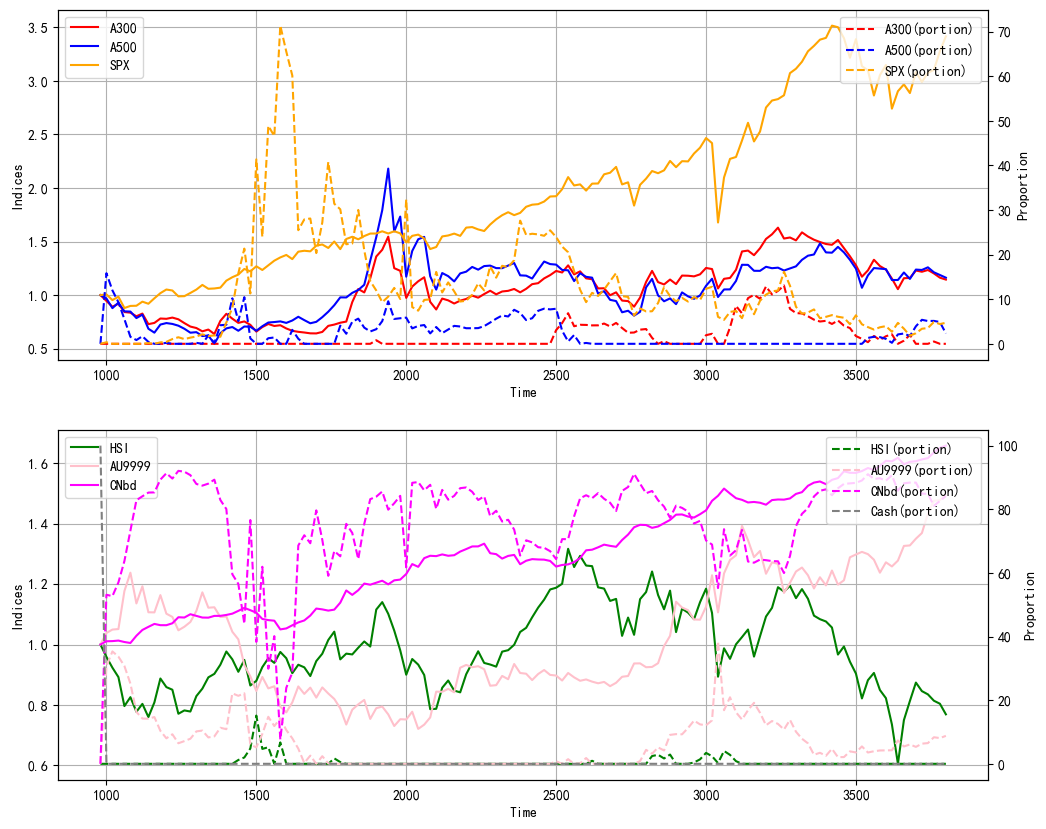

In [192]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 5.13%
Yearly Maximum Drawdown: -5.29%


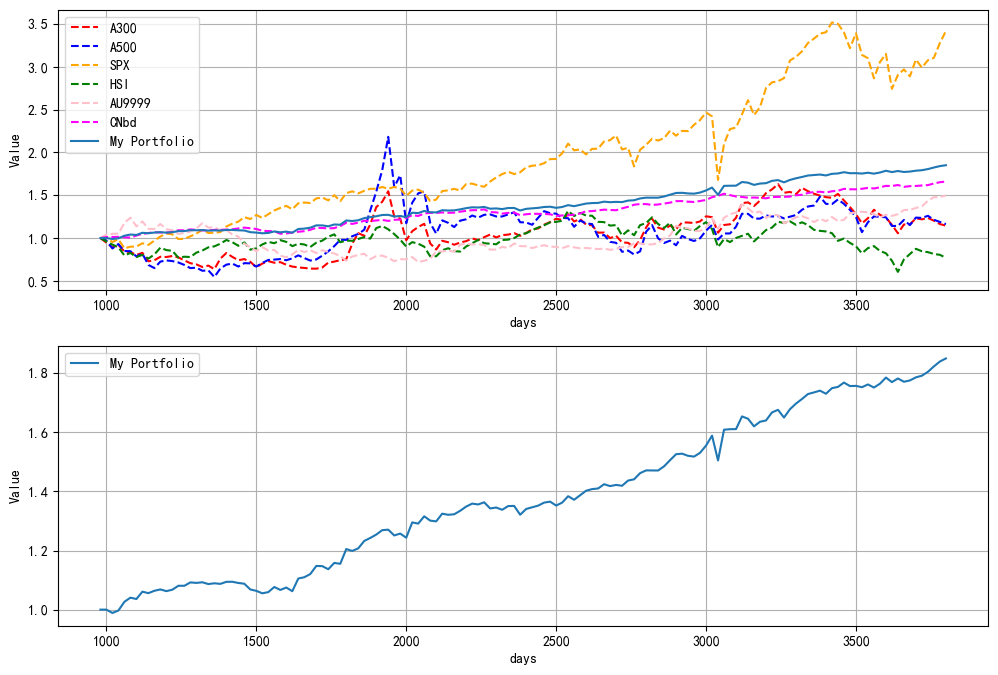

In [193]:
draw_profit()

### VIX指数做波动率预测

In [226]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.009
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf, R,q)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    
#     try:
#         opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
#         _opt1_port = np.array(list(opt1.efficient_return(0.07).values())) * 100
#     except:
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1000
Expected annual return: 14.7%
Annual volatility: 9.5%
Sharpe Ratio: 1.33
1020
Expected annual return: 12.0%
Annual volatility: 8.3%
Sharpe Ratio: 1.20
1040
Expected annual return: 11.4%
Annual volatility: 8.0%
Sharpe Ratio: 1.17
1060
Expected annual return: 10.8%
Annual volatility: 8.5%
Sharpe Ratio: 1.04
1080
Expected annual return: 10.3%
Annual volatility: 7.0%
Sharpe Ratio: 1.20
1100
Expected annual return: 8.1%
Annual volatility: 4.9%
Sharpe Ratio: 1.24
1120
Expected annual return: 8.5%
Annual volatility: 4.7%
Sharpe Ratio: 1.39
1140
Expected annual return: 8.5%
Annual volatility: 4.5%
Sharpe Ratio: 1.44
1160
Expected annual return: 7.4%
Annual volatility: 4.2%
Sharpe Ratio: 1.29
1180
Expected annual return: 8.1%
Annual volatility: 3.6%
Sharpe Ratio: 1.70
1200
Expected annual return: 7.5%
Annual volatility: 3.4%
Sharpe Ratio: 1.61
1220
Expected annual return: 7.0%
Annual volatility: 3.4%
Sharpe Ratio: 1.48
1240
Expected annual return: 6.9%
Annual volatility: 3.5%
Sharpe Ratio:

Expected annual return: 6.3%
Annual volatility: 3.8%
Sharpe Ratio: 1.14
3160
Expected annual return: 6.0%
Annual volatility: 4.0%
Sharpe Ratio: 1.02
3180
Expected annual return: 5.1%
Annual volatility: 4.0%
Sharpe Ratio: 0.78
3200
Expected annual return: 6.2%
Annual volatility: 4.1%
Sharpe Ratio: 1.01
3220
Expected annual return: 6.4%
Annual volatility: 4.2%
Sharpe Ratio: 1.05
3240
Expected annual return: 5.7%
Annual volatility: 4.5%
Sharpe Ratio: 0.82
3260
Expected annual return: 6.8%
Annual volatility: 5.1%
Sharpe Ratio: 0.94
3280
Expected annual return: 7.8%
Annual volatility: 4.1%
Sharpe Ratio: 1.41
3300
Expected annual return: 6.2%
Annual volatility: 3.3%
Sharpe Ratio: 1.29
3320
Expected annual return: 6.7%
Annual volatility: 3.0%
Sharpe Ratio: 1.59
3340
Expected annual return: 6.7%
Annual volatility: 2.9%
Sharpe Ratio: 1.59
3360
Expected annual return: 6.6%
Annual volatility: 2.9%
Sharpe Ratio: 1.57
3380
Expected annual return: 6.7%
Annual volatility: 2.6%
Sharpe Ratio: 1.79
3400

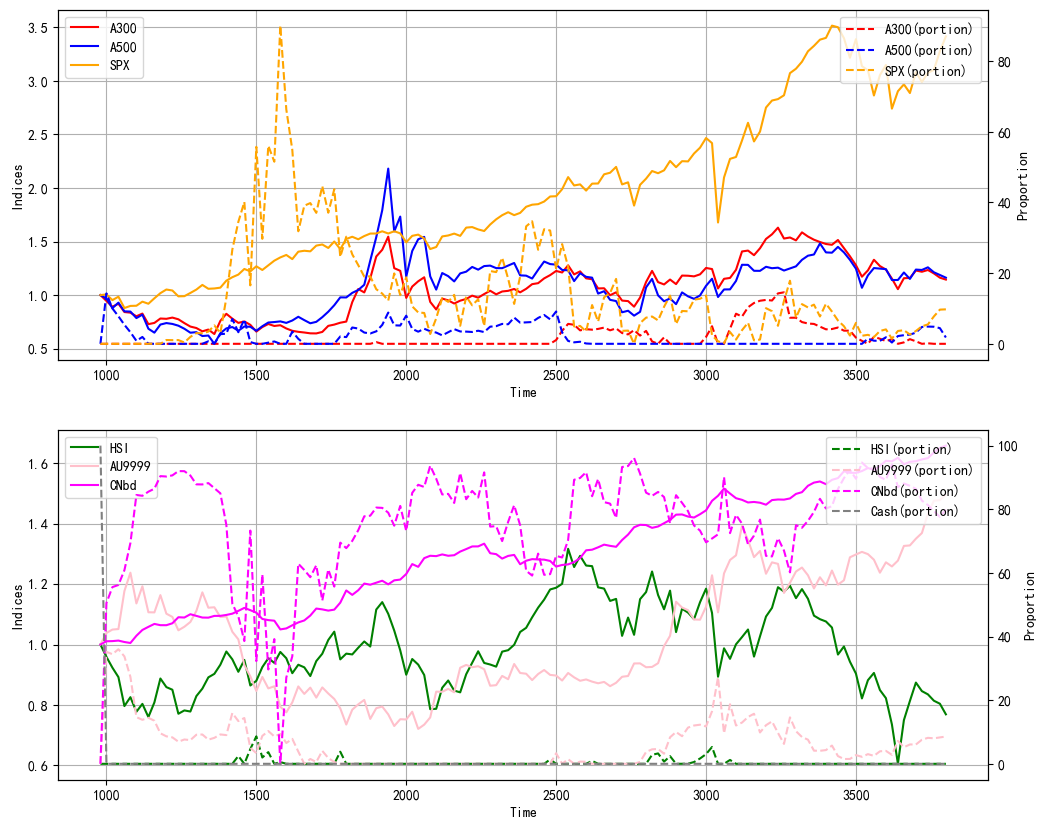

In [227]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 5.08%
Yearly Maximum Drawdown: -3.48%


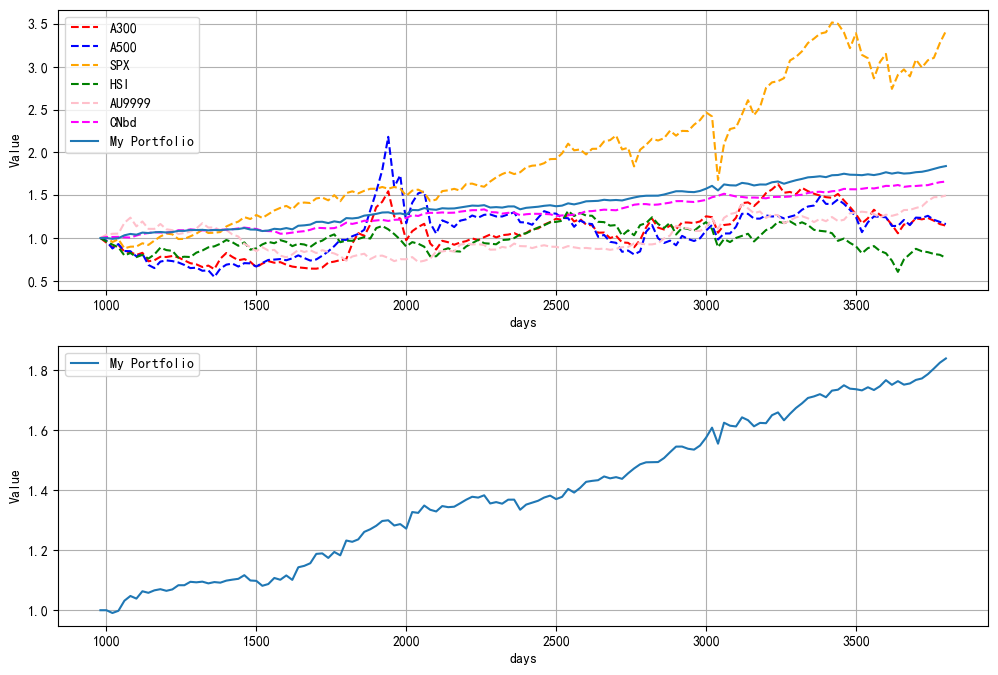

In [228]:
draw_profit()

### 直接把VIX指数放到MV优化器里

In [200]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.009
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    if maxRSI[n_ptf - 1] >= 70:
        view_mean[n_ptf - 1] -= 0.0015
    if minRSI[n_ptf - 1] <= 30:
        view_mean[n_ptf - 1] += 0.0008
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    if 0.15 > meanMTM[n_ptf -1] > 0.1:
        view_mean[n_ptf - 1] += 0.0008
    elif -0.15 < meanMTM[n_ptf - 1] < -0.1:
        view_mean[n_ptf - 1] -= 0.001
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    b = np.append(np.array(1.0,dtype=np.float64), view_mean).reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
        
    SPX_IV = SPX_VIX.loc[time, '收盘价']*0.01
    vol_scale = SPX_IV / np.sqrt(sim_cov[2,2])
    sim_cov[:,2] *= vol_scale
    sim_cov[2,:] *= vol_scale
    
    
#     try:
#         opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
#         _opt1_port = np.array(list(opt1.efficient_return(0.07).values())) * 100
#     except:
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1000
Expected annual return: 6.1%
Annual volatility: 2.6%
Sharpe Ratio: 1.56
1020
Expected annual return: 6.0%
Annual volatility: 2.6%
Sharpe Ratio: 1.52
1040
Expected annual return: 5.9%
Annual volatility: 2.6%
Sharpe Ratio: 1.51
1060
Expected annual return: 5.5%
Annual volatility: 2.5%
Sharpe Ratio: 1.41
1080
Expected annual return: 5.6%
Annual volatility: 2.5%
Sharpe Ratio: 1.41
1100
Expected annual return: 5.6%
Annual volatility: 2.5%
Sharpe Ratio: 1.41
1120
Expected annual return: 5.6%
Annual volatility: 2.5%
Sharpe Ratio: 1.42
1140
Expected annual return: 5.7%
Annual volatility: 2.6%
Sharpe Ratio: 1.45
1160
Expected annual return: 5.8%
Annual volatility: 2.6%
Sharpe Ratio: 1.48
1180
Expected annual return: 6.0%
Annual volatility: 2.6%
Sharpe Ratio: 1.53
1200
Expected annual return: 6.3%
Annual volatility: 2.7%
Sharpe Ratio: 1.61
1220
Expected annual return: 6.1%
Annual volatility: 2.6%
Sharpe Ratio: 1.56
1240
Expected annual return: 5.8%
Annual volatility: 2.6%
Sharpe Ratio: 1.48

Expected annual return: 5.8%
Annual volatility: 2.6%
Sharpe Ratio: 1.47
3240
Expected annual return: 5.6%
Annual volatility: 2.5%
Sharpe Ratio: 1.42
3260
Expected annual return: 5.7%
Annual volatility: 2.6%
Sharpe Ratio: 1.45
3280
Expected annual return: 6.1%
Annual volatility: 2.6%
Sharpe Ratio: 1.56
3300
Expected annual return: 5.8%
Annual volatility: 2.6%
Sharpe Ratio: 1.48
3320
Expected annual return: 6.2%
Annual volatility: 2.6%
Sharpe Ratio: 1.58
3340
Expected annual return: 6.1%
Annual volatility: 2.6%
Sharpe Ratio: 1.56
3360
Expected annual return: 6.1%
Annual volatility: 2.6%
Sharpe Ratio: 1.56
3380
Expected annual return: 6.0%
Annual volatility: 2.6%
Sharpe Ratio: 1.54
3400
Expected annual return: 6.2%
Annual volatility: 2.7%
Sharpe Ratio: 1.60
3420
Expected annual return: 6.1%
Annual volatility: 2.6%
Sharpe Ratio: 1.56
3440
Expected annual return: 5.9%
Annual volatility: 2.6%
Sharpe Ratio: 1.50
3460
Expected annual return: 5.8%
Annual volatility: 2.6%
Sharpe Ratio: 1.46
3480

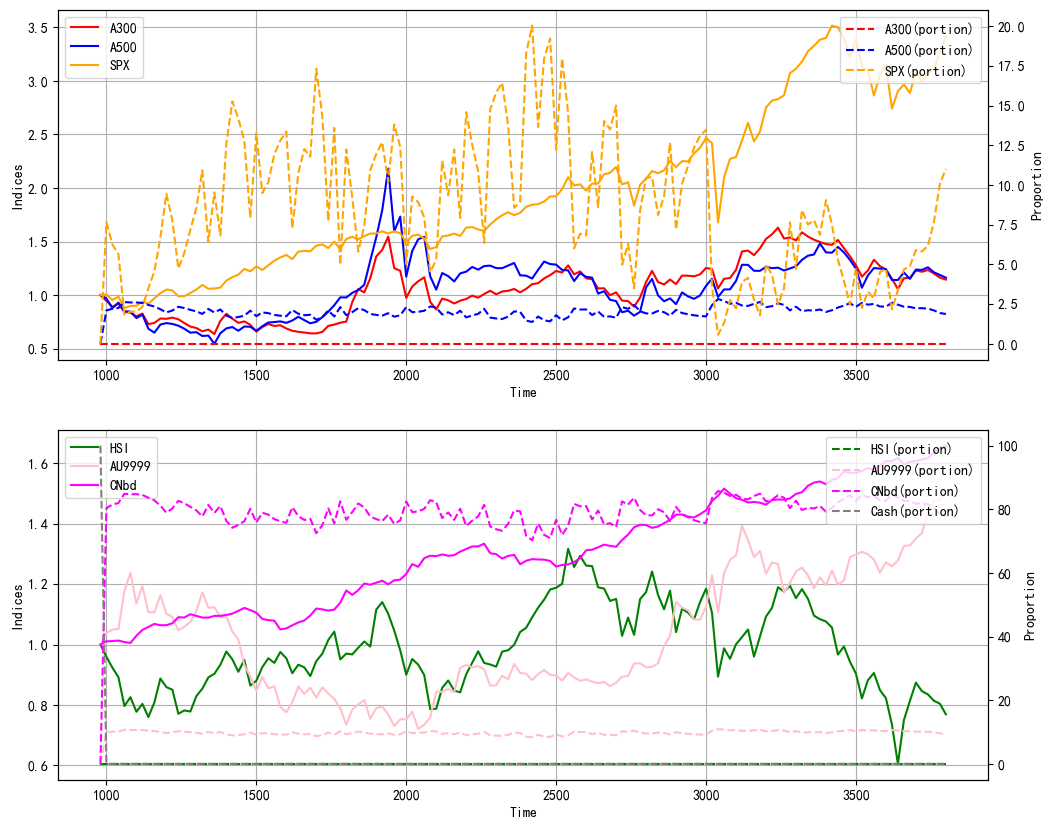

In [201]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 4.5%
Yearly Maximum Drawdown: -5.58%


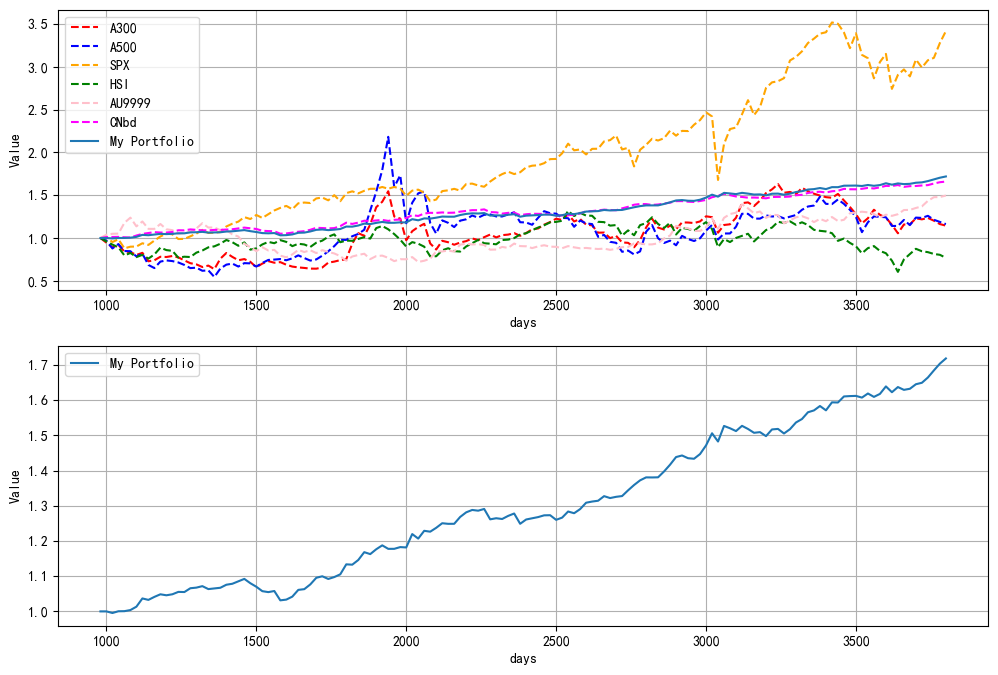

In [202]:
draw_profit()

### 国盛论文提出的风险目标

最小化双边0.5%换手费用下，未来一个月收益小于1%或者最大回撤超过-0.6%的概率

In [156]:
@njit  # 加速加速太慢了
def MC_p(this_ptf: np.ndarray, last_ptf: np.ndarray, paths: np.ndarray) -> float:
    '''
    计算Monte Carlo模拟的概率
    last_ptf: 上月持仓比例
    this_ptf: 本月持仓比例
    paths: 模拟的路径
    '''
    def maximum_accumulate(A):
        r = np.empty(len(A))
        t = -np.inf
        for i in range(len(A)):
            t = np.maximum(t, A[i])
            r[i] = t
        return r
    last_ptf /= last_ptf.sum()   # 持仓比例归一化
    this_ptf /= this_ptf.sum()
    
    trade_cost = np.abs(this_ptf - last_ptf).sum() * 0.005 / 2
    
    cnt = 0   # 频率统计
    
    for i in range(paths.shape[0]):
        path = paths[i]
        value_series = path.T @ this_ptf[:-1] + this_ptf[-1] # 计算给定path在当月持仓下的价值变化（非现金资产 + 现金）
        p = np.argmax(maximum_accumulate(value_series) - value_series)
        if p == 0:
            max_drawdown = 0
        else:
            q = np.argmax(value_series[:p])
            max_drawdown = (value_series[p] - value_series[q]) / value_series[q]
        
        earning = value_series[-1] - 1
        if max_drawdown <= -0.015 or earning <= 0.02 + trade_cost:
            cnt += 1
    return cnt / paths.shape[0]

In [157]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0, 100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[max(time-1000,0):time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.007
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(5000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1))
    if opt1_port.iloc[:,-1][-1] == 100.:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons, args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 1e-1})
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

1000
Sim ended.
     fun: 0.794
     jac: array([ 0.202,  0.186,  0.052,  0.126,  0.068, -0.014, -0.03 ])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00000000e+00, 5.51035872e-02, 1.60911336e-01, 1.28000317e-21,
       4.55153422e-01, 4.16286185e-17, 3.28831655e-01])
1020
Sim ended.
     fun: 0.7652
     jac: array([0.24 , 0.098, 0.102, 0.162, 0.106, 0.1  , 0.102])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 3.74382563e-02, 1.22127518e-01, 3.21585645e-18,
       4.17662322e-01, 9.22224873e-02, 3.30549416e-01])
1040
Sim ended.
     fun: 0.7724
     jac: array([0.2  , 0.162, 0.074, 0.068, 0.078, 0.054, 0.004])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([5.40093251e-17, 1.26844929e-02, 1.25082423e-01, 3.60481660e-02,


     fun: 0.7582
     jac: array([0.124, 0.082, 0.018, 0.048, 0.026, 0.018, 0.088])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.75282811e-17, 1.00075538e-21, 3.87776401e-01, 3.96726174e-02,
       2.71158872e-01, 3.01392110e-01, 1.77261189e-19])
1500
Sim ended.
     fun: 0.7238
     jac: array([0.14 , 0.134, 0.028, 0.036, 0.028, 0.018, 0.092])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([1.70432794e-18, 2.05494212e-17, 5.54424774e-01, 5.26455030e-02,
       1.76082246e-01, 2.16847476e-01, 5.50169244e-18])
1520
Sim ended.
     fun: 0.7452
     jac: array([0.14 , 0.126, 0.02 , 0.092, 0.052, 0.034, 0.06 ])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.24880406e-18, 6.40975977e-18, 4.93000340e-01, 1.67488762e-02,
       1.89415278e-01,

     fun: 0.7526
     jac: array([0.052, 0.034, 0.04 , 0.024, 0.156, 0.036, 0.126])
 message: 'Optimization terminated successfully'
    nfev: 77
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([8.82967474e-08, 1.46700432e-01, 5.15658671e-01, 1.46453930e-02,
       5.63959154e-18, 3.22995415e-01, 1.42653195e-18])
1980
Sim ended.
     fun: 0.7594
     jac: array([0.132, 0.082, 0.062, 0.148, 0.16 , 0.064, 0.114])
 message: 'Optimization terminated successfully'
    nfev: 61
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([6.07490005e-22, 8.52858053e-02, 5.95292482e-01, 6.93883969e-18,
       2.83212749e-17, 3.19421713e-01, 0.00000000e+00])
2000
Sim ended.
     fun: 0.7946
     jac: array([0.098, 0.09 , 0.062, 0.074, 0.15 , 0.034, 0.058])
 message: 'Optimization terminated successfully'
    nfev: 90
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.22140931e-17, 9.68424492e-02, 4.50430959e-01, 1.55031828e-03,
       2.75871928e-17,

     fun: 0.7728
     jac: array([0.034, 0.064, 0.014, 0.054, 0.102, 0.062, 0.078])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([7.51207378e-02, 1.49417183e-01, 4.87757000e-01, 4.27988934e-03,
       1.76107331e-04, 2.83036732e-01, 2.12350872e-04])
2460
Sim ended.
     fun: 0.7362
     jac: array([0.042, 0.05 , 0.048, 0.094, 0.206, 0.122, 0.208])
 message: 'Optimization terminated successfully'
    nfev: 74
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.10729711e-01, 9.42969541e-02, 5.62650753e-01, 1.26972255e-03,
       1.68659875e-17, 2.25656512e-01, 5.39634706e-03])
2480
Sim ended.
     fun: 0.7434
     jac: array([0.036, 0.068, 0.038, 0.08 , 0.158, 0.118, 0.17 ])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.02142224e-01, 7.30166507e-02, 5.78514535e-01, 6.56402307e-02,
       1.37023180e-17,

     fun: 0.7906
     jac: array([0.086, 0.164, 0.024, 0.108, 0.032, 0.078, 0.152])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([2.37093798e-01, 1.18422303e-07, 2.99102856e-01, 7.97140212e-22,
       2.76750690e-01, 1.87052537e-01, 1.64249270e-17])
2940
Sim ended.
     fun: 0.7748
     jac: array([0.112, 0.242, 0.034, 0.058, 0.024, 0.016, 0.112])
 message: 'Optimization terminated successfully'
    nfev: 102
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([4.56797559e-16, 2.78878856e-21, 5.01582015e-01, 8.81012007e-15,
       3.97269742e-01, 1.01148243e-01, 1.71093555e-21])
2960
Sim ended.
     fun: 0.759
     jac: array([0.144, 0.274, 0.01 , 0.116, 0.016, 0.068, 0.124])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([3.21386819e-21, 2.63554442e-17, 4.96013582e-01, 4.35821603e-19,
       4.40490571e-0

     fun: 0.7418
     jac: array([0.146, 0.144, 0.046, 0.182, 0.034, 0.02 , 0.052])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.07268769e-01, 3.83237367e-17, 4.32354178e-01, 3.05193309e-22,
       3.54613041e-01, 1.05764012e-01, 5.57435471e-17])
3420
Sim ended.
     fun: 0.7254
     jac: array([0.112, 0.146, 0.09 , 0.178, 0.086, 0.07 , 0.102])
 message: 'Optimization terminated successfully'
    nfev: 83
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.53053366e-02, 1.56579335e-17, 4.41184362e-01, 2.24439783e-17,
       3.31658823e-01, 1.81851478e-01, 2.85330706e-17])
3440
Sim ended.
     fun: 0.7454
     jac: array([0.048, 0.084, 0.08 , 0.16 , 0.05 , 0.028, 0.072])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.75919515e-07, 2.93206634e-22, 4.13364763e-01, 1.58942017e-17,
       3.59002536e-01,

In [159]:
np.round(_opt1_port,2)

,3800
A300,0.00
A500,4.27
SPX,32.43
HSI,0.00
AU9999,53.03
CNbd,10.27
Cash,0.00


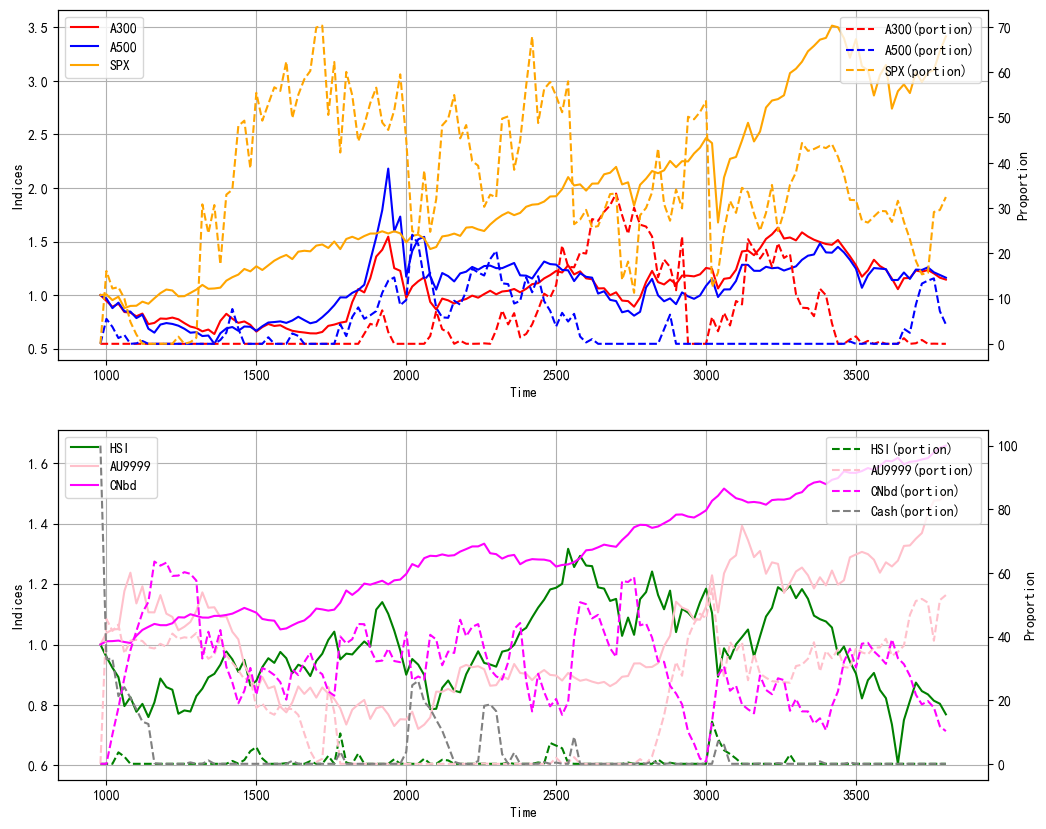

In [160]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 6.28%
Yearly Maximum Drawdown: -12.59%


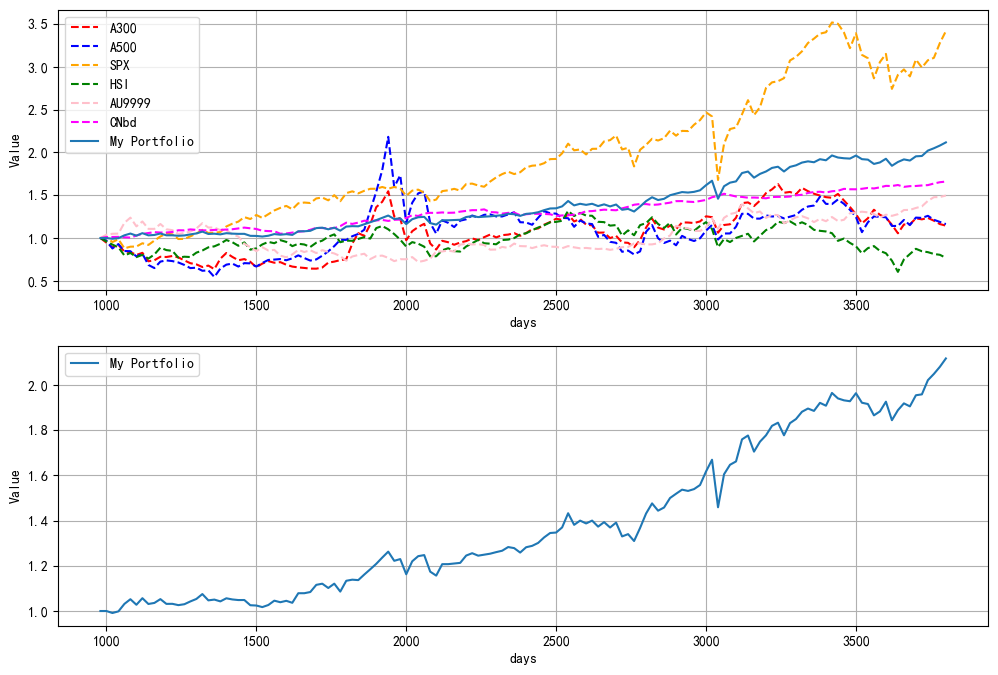

In [163]:
draw_profit()

### 国盛论文提出的风险目标+最优夏普 杂交

In [216]:
risk_free = 0.03

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0, 100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[max(time-1000,0):time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.007
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.5 + q2 * 0.5
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(5000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1))
    if opt1_port.iloc[:,-1][-1] == 100.:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons, args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 1e-1})
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    
    if sim_mean.max() < risk_free:
        _opt2_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt2 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt2_port = np.array(list(opt2.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt2_port = pd.DataFrame(_opt2_port, index = [*names, 'Cash'], columns = [time])
    _opt1_port = _opt1_port * 0.2 + _opt2_port * 0.8

    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

1000
Sim ended.
1020
Sim ended.
1040
Sim ended.
1060
Sim ended.
1080
Sim ended.
1100
Sim ended.
1120
Sim ended.
1140
Sim ended.
1160
Sim ended.
1180
Sim ended.
1200
Sim ended.
1220
Sim ended.
1240
Sim ended.
1260
Sim ended.
1280
Sim ended.
1300
Sim ended.
1320
Sim ended.
1340
Sim ended.
1360
Sim ended.
1380
Sim ended.
1400
Sim ended.
1420
Sim ended.
1440
Sim ended.
1460
Sim ended.
1480
Sim ended.
1500
Sim ended.
1520
Sim ended.
1540
Sim ended.
1560
Sim ended.
1580
Sim ended.
1600
Sim ended.
1620
Sim ended.
1640
Sim ended.
1660
Sim ended.
1680
Sim ended.
1700
Sim ended.
1720
Sim ended.
1740
Sim ended.
1760
Sim ended.
1780
Sim ended.
1800
Sim ended.
1820
Sim ended.
1840
Sim ended.
1860
Sim ended.
1880
Sim ended.
1900
Sim ended.
1920
Sim ended.
1940
Sim ended.
1960
Sim ended.
1980
Sim ended.
2000
Sim ended.
2020
Sim ended.
2040
Sim ended.
2060
Sim ended.
2080
Sim ended.
2100
Sim ended.
2120
Sim ended.
2140
Sim ended.
2160
Sim ended.
2180
Sim ended.
2200
Sim ended.
2220
Sim ended.
2240
Sim

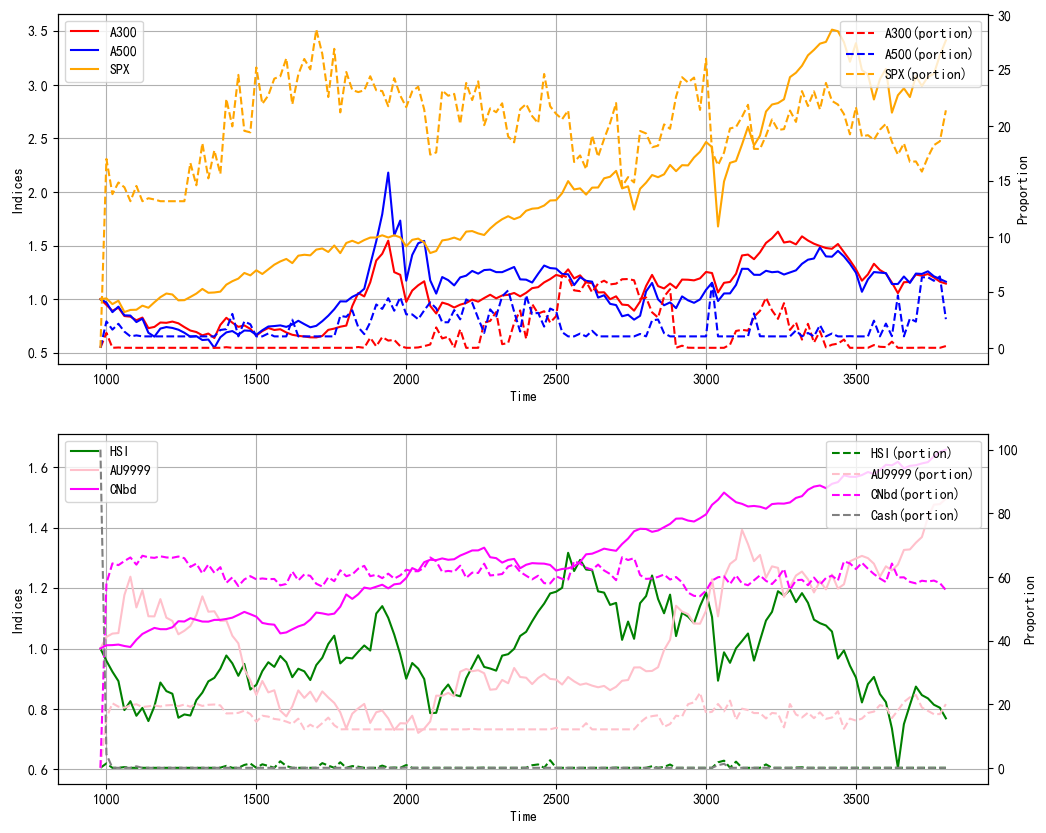

In [217]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 5.21%
Yearly Maximum Drawdown: -7.38%


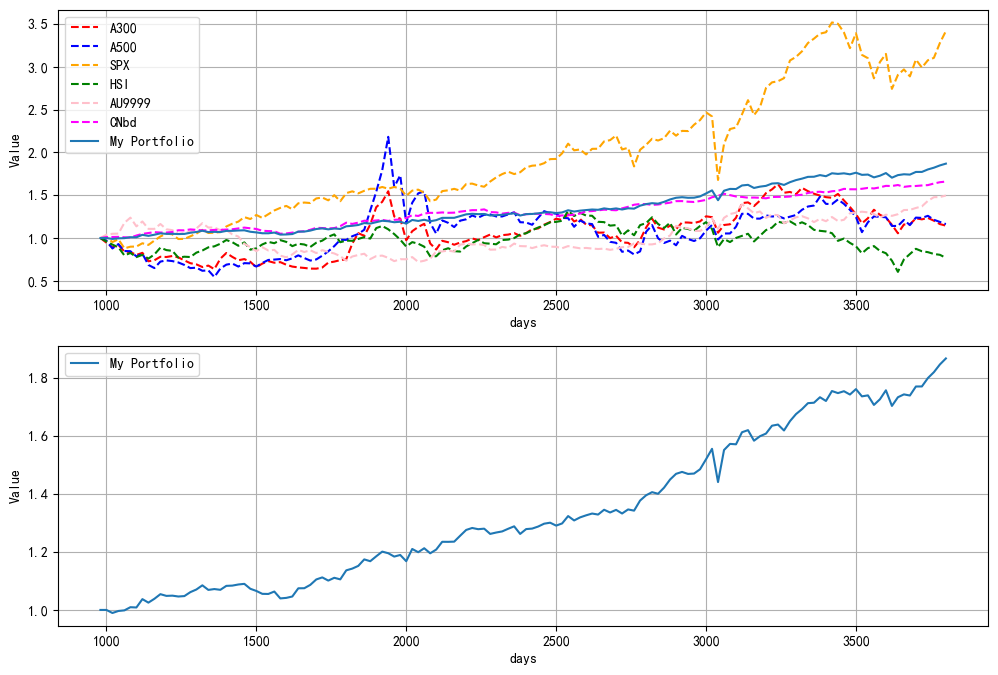

In [218]:
draw_profit()

### 无RSI无EP纯Monte Carlo情况

In [219]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time-1000:time], columns=names)
    R = R_df.values
    S = R.shape[0]
    
    p = np.ones((S, 1),dtype=np.float64) / S    # Prior distribution
    
    sim_end_time = 20
    sim_series = price_MonteCarlo(20000, n_ptf,R, p)
    sim_last = np.c_[sim_series,np.power((np.ones(sim_series.shape[0]) / (1+risk_free)), sim_end_time/250).reshape(-1,1)]
    sim_mean = np.power(np.mean(sim_last, axis=0), 250/sim_end_time) - 1
    sim_cov = np.cov(sim_last.T) * 250 / sim_end_time
    
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1000
Expected annual return: 16.1%
Annual volatility: 10.9%
Sharpe Ratio: 1.29
1020
Expected annual return: 13.8%
Annual volatility: 10.3%
Sharpe Ratio: 1.14
1040
Expected annual return: 11.9%
Annual volatility: 8.7%
Sharpe Ratio: 1.14
1060
Expected annual return: 10.7%
Annual volatility: 8.0%
Sharpe Ratio: 1.09
1080
Expected annual return: 10.5%
Annual volatility: 6.6%
Sharpe Ratio: 1.28
1100
Expected annual return: 8.7%
Annual volatility: 5.0%
Sharpe Ratio: 1.33
1120
Expected annual return: 8.7%
Annual volatility: 4.7%
Sharpe Ratio: 1.45
1140
Expected annual return: 8.5%
Annual volatility: 4.7%
Sharpe Ratio: 1.37
1160
Expected annual return: 8.0%
Annual volatility: 4.3%
Sharpe Ratio: 1.39
1180
Expected annual return: 7.6%
Annual volatility: 4.3%
Sharpe Ratio: 1.29
1200
Expected annual return: 7.5%
Annual volatility: 4.0%
Sharpe Ratio: 1.37
1220
Expected annual return: 7.3%
Annual volatility: 4.1%
Sharpe Ratio: 1.28
1240
Expected annual return: 7.1%
Annual volatility: 4.0%
Sharpe Rati

Expected annual return: 7.1%
Annual volatility: 4.0%
Sharpe Ratio: 1.28
3160
Expected annual return: 6.8%
Annual volatility: 4.0%
Sharpe Ratio: 1.20
3180
Expected annual return: 6.4%
Annual volatility: 4.0%
Sharpe Ratio: 1.09
3200
Expected annual return: 6.7%
Annual volatility: 4.7%
Sharpe Ratio: 1.01
3220
Expected annual return: 6.8%
Annual volatility: 4.4%
Sharpe Ratio: 1.08
3240
Expected annual return: 7.1%
Annual volatility: 4.5%
Sharpe Ratio: 1.13
3260
Expected annual return: 7.0%
Annual volatility: 4.7%
Sharpe Ratio: 1.06
3280
Expected annual return: 6.5%
Annual volatility: 4.0%
Sharpe Ratio: 1.13
3300
Expected annual return: 6.2%
Annual volatility: 3.2%
Sharpe Ratio: 1.31
3320
Expected annual return: 6.1%
Annual volatility: 2.9%
Sharpe Ratio: 1.39
3340
Expected annual return: 6.0%
Annual volatility: 2.8%
Sharpe Ratio: 1.42
3360
Expected annual return: 6.0%
Annual volatility: 2.8%
Sharpe Ratio: 1.42
3380
Expected annual return: 6.4%
Annual volatility: 2.6%
Sharpe Ratio: 1.70
3400

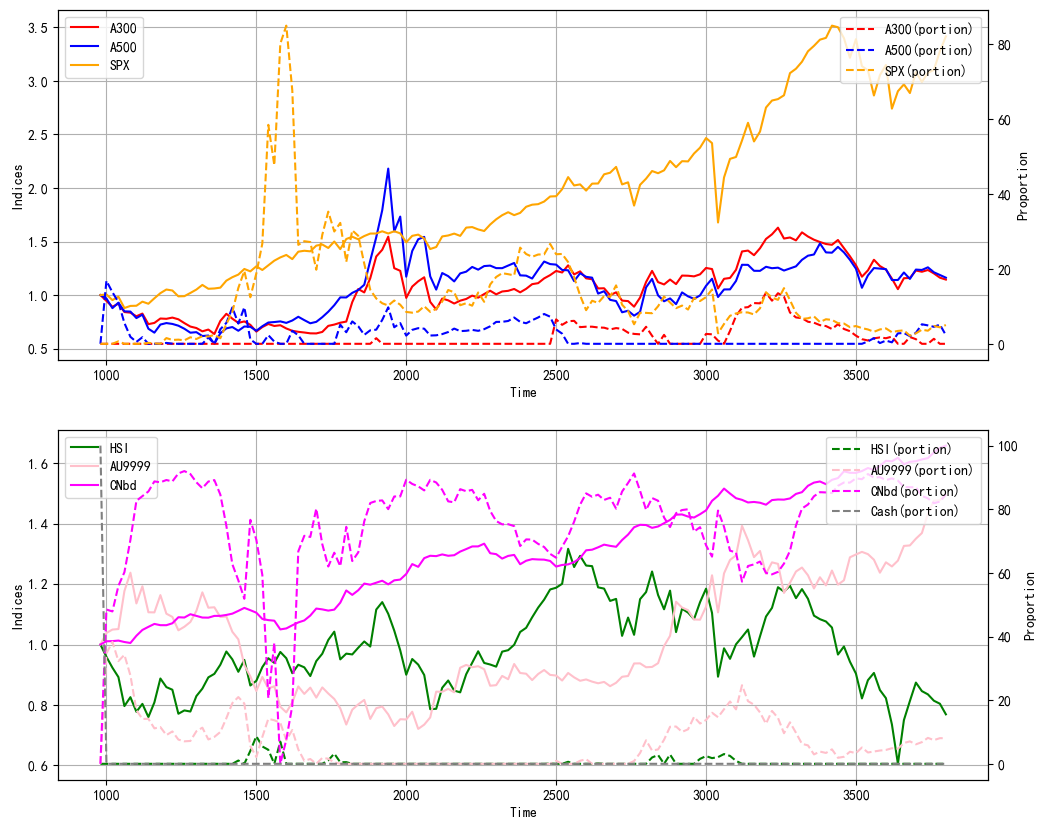

In [220]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 4.64%
Yearly Maximum Drawdown: -6.02%


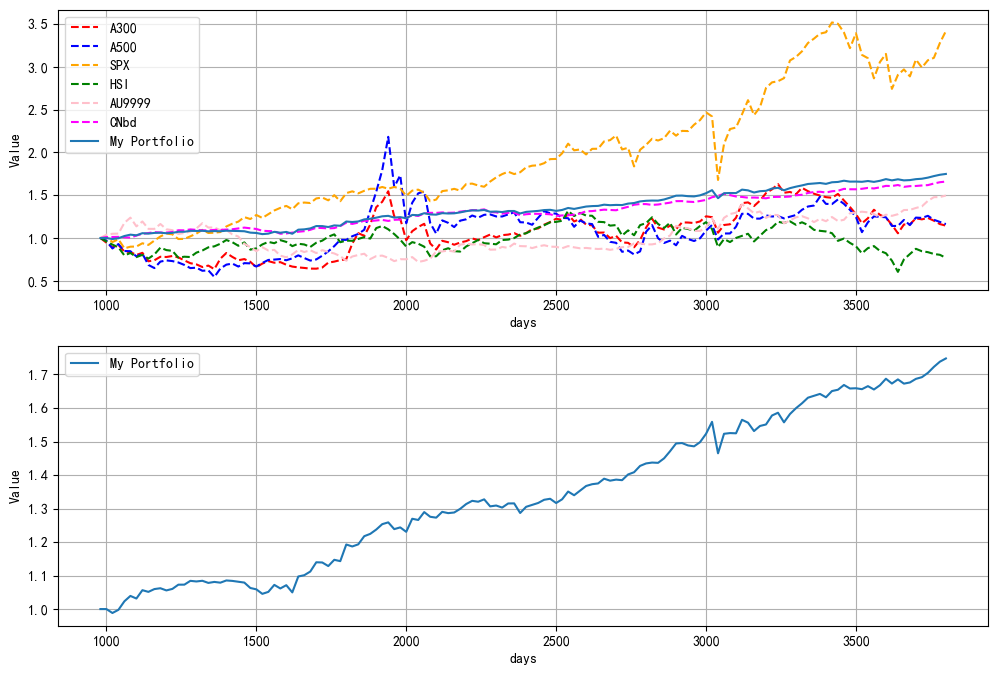

In [221]:
draw_profit()

### 无Monte Carlo

In [169]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - 20])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[time - 1000:time], columns=names)
    R = R_df.values
    R = np.c_[R, np.ones(R.shape[0]) * np.power(1/(1+risk_free), 1/252) - 1]
    S = R.shape[0]
    
    p = np.ones((S, 1),dtype=np.float64) / S    # Prior distribution
    
    # 计算期望与协方差
    sim_mean = np.mean(R,axis = 0)
    sim_cov = np.cov(R.T)
    
    if sim_mean.max() < risk_free:
        _opt1_port = pd.DataFrame([.0,.0,.0,.0,.0,100.], index = [*names, 'Cash'], columns = [time])
    else:
        opt1 = pfopt.efficient_frontier.EfficientFrontier(sim_mean, sim_cov)
        _opt1_port = np.array(list(opt1.max_sharpe(risk_free_rate=risk_free).values()))  * 100
        _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)
    opt1.portfolio_performance(verbose=True)

1000
Expected annual return: 9.7%
Annual volatility: 126.4%
Sharpe Ratio: 0.06
1020
Expected annual return: 8.4%
Annual volatility: 120.0%
Sharpe Ratio: 0.05
1040
Expected annual return: 8.0%
Annual volatility: 117.4%
Sharpe Ratio: 0.05
1060
Expected annual return: 8.0%
Annual volatility: 117.7%
Sharpe Ratio: 0.05
1080
Expected annual return: 9.2%
Annual volatility: 125.3%
Sharpe Ratio: 0.06
1100
Expected annual return: 6.7%
Annual volatility: 96.5%
Sharpe Ratio: 0.05
1120
Expected annual return: 5.0%
Annual volatility: 56.1%
Sharpe Ratio: 0.05
1140
Expected annual return: 4.9%
Annual volatility: 60.2%
Sharpe Ratio: 0.05
1160
Expected annual return: 4.1%
Annual volatility: 47.4%
Sharpe Ratio: 0.04
1180
Expected annual return: 4.1%
Annual volatility: 50.2%
Sharpe Ratio: 0.04
1200
Expected annual return: 3.4%
Annual volatility: 37.3%
Sharpe Ratio: 0.04
1220
Expected annual return: 3.5%
Annual volatility: 41.7%
Sharpe Ratio: 0.04
1240
Expected annual return: 3.0%
Annual volatility: 31.5%


Expected annual return: 4.9%
Annual volatility: 75.5%
Sharpe Ratio: 0.04
3220
Expected annual return: 4.9%
Annual volatility: 69.6%
Sharpe Ratio: 0.04
3240
Expected annual return: 5.1%
Annual volatility: 71.8%
Sharpe Ratio: 0.04
3260
Expected annual return: 5.7%
Annual volatility: 87.3%
Sharpe Ratio: 0.04
3280
Expected annual return: 5.3%
Annual volatility: 73.5%
Sharpe Ratio: 0.04
3300
Expected annual return: 5.3%
Annual volatility: 70.6%
Sharpe Ratio: 0.05
3320
Expected annual return: 5.2%
Annual volatility: 70.9%
Sharpe Ratio: 0.05
3340
Expected annual return: 5.3%
Annual volatility: 74.8%
Sharpe Ratio: 0.04
3360
Expected annual return: 5.7%
Annual volatility: 89.1%
Sharpe Ratio: 0.04
3380
Expected annual return: 5.1%
Annual volatility: 69.3%
Sharpe Ratio: 0.04
3400
Expected annual return: 5.4%
Annual volatility: 83.6%
Sharpe Ratio: 0.04
3420
Expected annual return: 5.6%
Annual volatility: 78.2%
Sharpe Ratio: 0.05
3440
Expected annual return: 5.8%
Annual volatility: 88.6%
Sharpe Rat

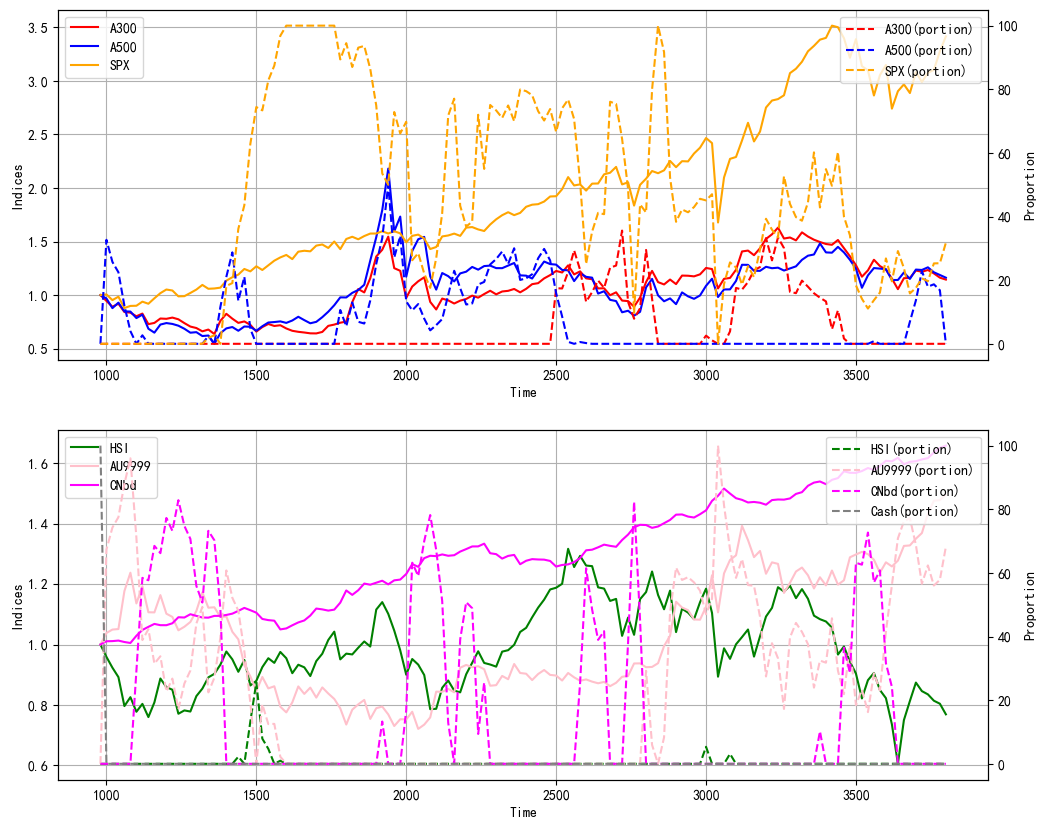

In [170]:
draw_ptf()

Start Date: 2011-04-07
End Date: 2023-07-24
Yearly Earning: 5.42%
Yearly Maximum Drawdown: -24.33%


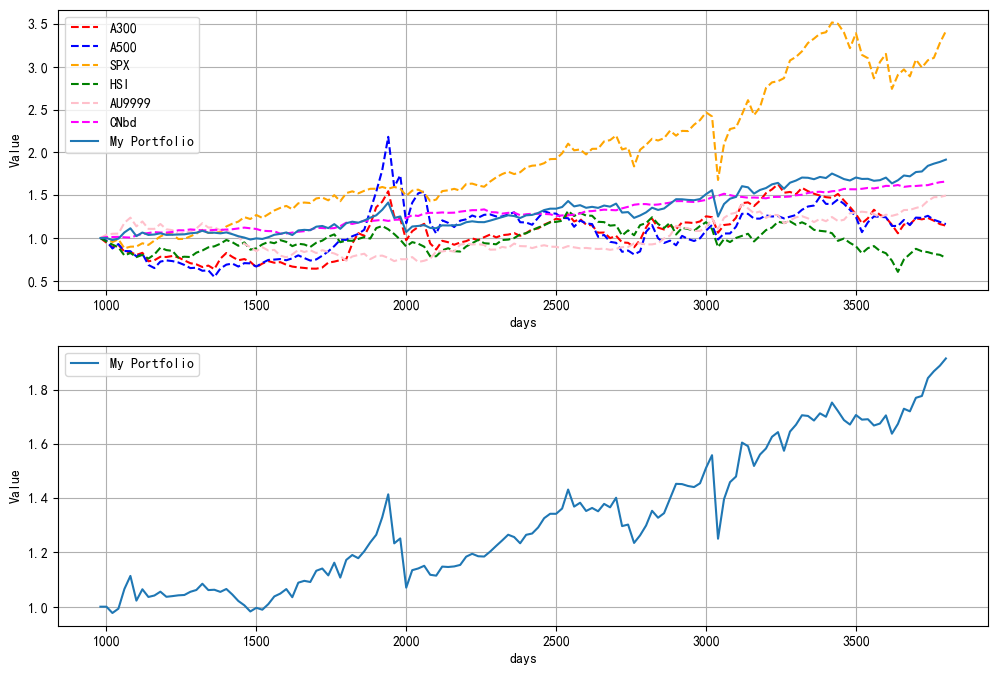

In [171]:
draw_profit()

## Ornstein-Ulenbeck过程

In [ ]:
def OU_MLE(time_series, dt, N):
    """
    Use Minimal Likelihood Estimation for OU process parameter
    """
    XX = time_series[:-1]
    YY = time_series[1:]
    
    Sx = np.sum(XX)
    Sy = np.sum(YY)
    Sxx = XX @ XX
    Sxy = XX @ YY
    Syy = YY @ YY

    mu_mle = (Sy*Sxx - Sx*Sxy) / (N*(Sxx-Sxy) - (Sx**2 - Sx*Sy) )
    theta_mle = -1/dt * np.log( (Sxy - mu_mle*Sx - mu_mle*Sy +N*mu_mle**2) 
                              / (Sxx - 2*mu_mle*Sx + N*mu_mle**2)  )
    sigma2_hat = ( Syy -2*np.exp(-theta_mle*dt)*Sxy + np.exp(-2*theta_mle*dt)*Sxx - 2*mu_mle*
                 (1-np.exp(-theta_mle*dt))*(Sy-np.exp(-theta_mle*dt)*Sx) + N*mu_mle**2 * 
                  (1-np.exp(-theta_mle*dt))**2 )/N
    sigma2_mle = sigma2_hat * 2*theta_mle / (1-np.exp(-2*theta_mle*dt))
    
    return mu_mle * theta_mle, theta_mle, sigma2_mle

In [ ]:
N = 500

Mu = []
Theta = []
Sigma2 = []

for i in range(prices.shape[0]):
    _mu, _theta, _sigma2  = OU_MLE(prices[i][:N], 1, N)
    Mu.append(_mu)
    Theta.append(_theta)
    Sigma2.append(_sigma2)
Mu = np.array(Mu)
Theta = np.diag(Theta)
# Estimated Sigma2
obv_sig2 = 2*np.dot(Theta,np.cov(prices[:,:N]))
print("Cov:\n", obv_sig2)
Sigma2 = obv_sig2- np.diag(np.diagonal(obv_sig2)) + np.diag(Sigma2)

print("Mu:", Mu)
print("Theta:\n", Theta)
print("Sigma2:\n",Sigma2)

In [ ]:
# Save data for MATLAB
scio.savemat('./Meucci/CalibratedParameters.mat',
             {'mu': Mu.reshape(-1,1), 'sig2': Sigma2,
            'theta': Theta, 'x0': prices[:,500]})
scio.savemat('./Meucci/path_daily.mat', {'A300_path': prices[0].reshape(-1,1), 'A500_path': prices[1].reshape(-1,1),
                                         'SPX_path': prices[2].reshape(-1,1), 'HSI_path': prices[3].reshape(-1,1), 'AU9999_path': prices[4].reshape(-1,1)})